In [181]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

Ask Sven:

wo Zitate nennen
- am Satzende zitieren
- wenn nachfolgende satz auch von gleiem Paper , dann erneut Zitat erwähnen
- außer wenn im satz direkter bezug gemacht wird, wie diese paper sagt auch aus, dass ... 
- (ebd)
- bei papern etc: ohne page number
- bei BUch, gr. Sachen: mit page referenzieren


Explor Ananlyse - raus aus ma text
- schreib einfach dass explo gemacht aber nr wichtigsten aussagen werden in thesis aufgegriffen
- plot wd ~ loss
- wichtigste plots die zur story passen
- PCA: schrieb kurz wieveile komponentes getestet
- dama

damage cases from ncv
- okay
- menition in discussion: that better to use hold-out set to predcit with best estim. on this, but just had not enough records for this

abs losses report instead of rel losses
- rel BN results
- 
abs loss :
- nur im vgl zu mean income
- im text schrieben wie umrechnen .. in abs zahlen bedeutetet dies xx 
- mv abs los plots to appendix
- nur zsm

visualize residual of modelled vs obs losses -> confidenc intervall (rather no)
y-axis resudals , x axis  obs rel. loss - scatterplot or with sm boxplots
- residuals ~ group by einz prädikator wenn intressant


proposal schicken - nope


Disc: 
- alles weitere nennen, was nicht gemacht wurde, 
- results aufgreifen und in relation zu unsicherheit beleuchten 
--> sind unsicherheiten so hoch dass die results wenig aussagekräfitg sind?
    - zumindest für LogReg zu unsicher um results zu trauen



Rule of thumbs : 10 datapoints = one parameter

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC df_predictorsset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [182]:
import sys, os
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import mpl_scatter_density # adds projection="scatter_density"
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


UTILS_PATH = os.path.join(os.path.abspath(""), "../", "utils")
sys.path.append(UTILS_PATH)
import settings as s
import figures as f
import evaluation_utils as eu

seed = s.seed
pd.set_option("display.max_columns", None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings("ignore")

targets = [("Target_relative_contentloss_euro", "rcloss"), ("Target_businessreduction","bred")]
target, target_plot = targets[1]
pred_target = f"pred_{target}"


## TODO move to config or settings , atomize into subpaths
## save models and their evaluation in following folders:
OUTPATH_BN = Path("../model_results/bayesian_network/businessreduction")
OUTPATH_BN.mkdir(parents=True, exist_ok=True)

OUTPATH_BRED = Path("../model_results/selected_features/degree_of_loss/")
OUTPATH_ESTIMATOR = Path("../models_trained/chance_of_loss/final_models/chance_of_loss/")
OUTPATH_FIGURES = Path("../figures")

In [183]:
## load train set for BN (HCMC, bred)
target_name = "businessreduction"
# df_hcmc = pd.read_excel(OUTPATH_BRED / f"final_predictors_Target_{target_name}.xlsx")
df_hcmc = pd.read_excel(OUTPATH_BRED / f"final_predictors_Target_{target_name}_income_cv.xlsx")

df_hcmc.drop("geometry", axis=1, inplace=True)
print(df_hcmc.shape)
df_hcmc.tail(2)




(356, 16)


,Target_businessreduction,emergency_measures,water_depth_cm,flowvelocity,bage,resilience,inundation_duration_h,precautionary_measures_lowcost,hh_monthly_income_euro,flood_experience,shp_content_value_euro,b_area,precautionary_measures_expensive,shp_avgmonthly_sale_euro,shp_employees,contaminations
354,10,0.500000,70.0,0.1,25.0,1.0,5.0,0.75,110.5,151,NaN,80.0,0.0,276.2,1,1
355,0,0.333333,100.0,0.1,5.0,0.0,3.0,0.25,0.0,36,NaN,33.0,0.0,736.5,2,1


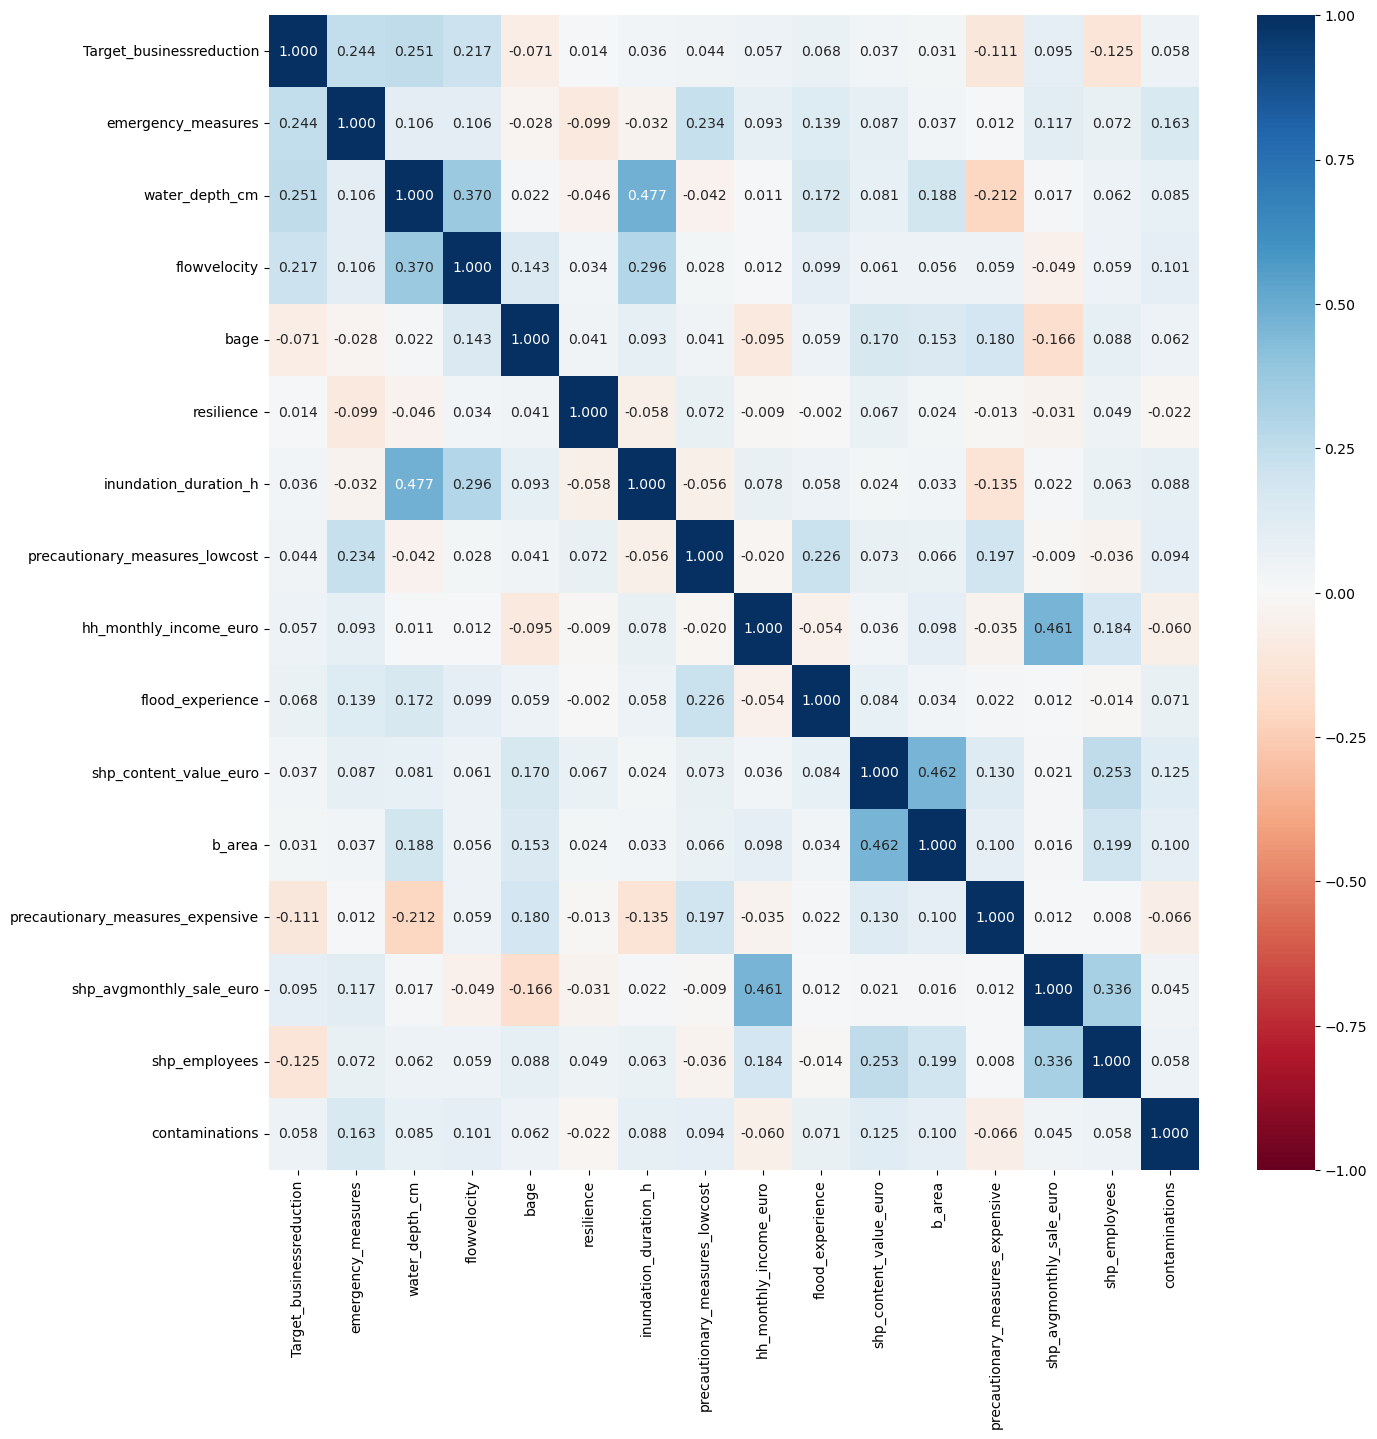

In [184]:
## find predictor with highest unconditional correlation to target
# f.plot_spearman_rank(df_hcmc)
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc.corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")

# fv most corr ~ target

--> water depth correlates strongest with rcloss

In [185]:
# dd = df_hcmc.loc[df_hcmc.inundation_duration_h < 30, :]
# print(df_hcmc.shape, dd.shape)
# # sns.regplot(x=dd.flowvelocity, y=dd.inundation_duration_h)
# f.plot_correlations(dd[[target, "flowvelocity", "inundation_duration_h", "water_depth_cm"]], 
#                     impute_na=True, outfile=OUTPATH_FIGURES / f"tst.png")

## Copula test

In [186]:
# #-----------------------------------------------------------------------------
# # Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
# #-----------------------------------------------------------------------------

# plt.figure(figsize=(20,15))
# M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
#                   names = df_hcmc_bn.columns,   # names of variables
#                   plot = True,               # create a plot (0=don"t create plot)
#                   fig_name = "empricial_corpula_all vars_bred")    # figure name
                  
# # The results of the goodness-of-fit test in terms of Cramer-von Mises
# # statistic highlight that the Gaussian copula is in majority of cases the 
# # most suitable for representing the dependency between variables, 
# # especially for the variable of interest (safety). This is important as
# # the method utilizes the Gaussian copula for dependence modelling.


# ## !! decalibration score = overall score if BN fullfills 

##### d-calibration score

In [187]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------


# # gaussian_distance : validation: 
# D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
#                             R,        # the rank correlation matrix 
#                             df_hcmc_bn,     # df_predictorsFrame with df_hcmc
#                             4000,     # number of samples drawn d-Cal(ERC,NRC)
#                             400,      # number of samples drawn d-Cal(NRC,BNRC)
#                             1000,     # number of iterations to compute CI
#                             Plot=True,          # create a plot (0=don"t create plot)
#                             Type="H",           # take Hellinger distance (default)
#                             fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN"s rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictorssets.


In [188]:
df_hcmc.head(2)#.shape

,Target_businessreduction,emergency_measures,water_depth_cm,flowvelocity,bage,resilience,inundation_duration_h,precautionary_measures_lowcost,hh_monthly_income_euro,flood_experience,shp_content_value_euro,b_area,precautionary_measures_expensive,shp_avgmonthly_sale_euro,shp_employees,contaminations
0,0,0.0,10.0,0.2,12.0,5.0,2.0,0.0,110.5,76,441.9,25.0,0.0,276.2,1,0
1,0,0.0,15.0,0.2,0.0,5.0,2.0,0.0,294.6,76,441.9,21.0,0.0,276.2,1,1


## Construct BN

In [189]:

# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f"bn_{target}"


# Define the variable names
# names_list = ["Target_businessreduction", "flowvelocity", "water_depth_cm", "b_area"]
names_list = ["Target_businessreduction", "emergency_measures", "flowvelocity", "water_depth_cm", 
              "shp_employees", "precautionary_measures_expensive"]#, "shp_avgmonthly_sale_euro"]#, "shp_avgmonthly_sale_euro"]#, "shp_content_value_euro"]#, "hh_monthly_income_euro" ]# "resilience", "precautionary_measures_lowcost", "hh_monthly_income_euro", "b_area"]#, "flood_experience"]#, "shp_content_value_euro"]#"flood_experience"] #, "b_area"]#, "inundation_duration_h"]
#   # flood_experience precautionary_measures_lowcost # 

# b_area bage income, inundation, prec_nonstruct, barea  = no imporvement as 4th var
# NOTE barea precautionary_measures_lowcost inundation resilience (flood_experience-stagnate)

print(df_hcmc.columns)


# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc[names_list]

names = {k: i for i, k in enumerate(names_list)}

print("Using following features:\n", names)

Index(['Target_businessreduction', 'emergency_measures', 'water_depth_cm',
       'flowvelocity', 'bage', 'resilience', 'inundation_duration_h',
       'precautionary_measures_lowcost', 'hh_monthly_income_euro',
       'flood_experience', 'shp_content_value_euro', 'b_area',
       'precautionary_measures_expensive', 'shp_avgmonthly_sale_euro',
       'shp_employees', 'contaminations'],
      dtype='object')
Using following features:
 {'Target_businessreduction': 0, 'emergency_measures': 1, 'flowvelocity': 2, 'water_depth_cm': 3, 'shp_employees': 4, 'precautionary_measures_expensive': 5}


In [190]:
# Extract number of nodes from df_hcmc
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N


## for CanTHo transfer, inkl all features
# parent_cell[0] = [1, 2, 3, 4, 5]                                             #   target (parents: all other features)
# parent_cell[1] = []                                                              # emerg
# parent_cell[2] = []                                                              # fv  
# parent_cell[3] = [2, 5]                                                             # wd  
# parent_cell[4] = []                                                              # employees  
# parent_cell[5] = []                                                              # prec_structural -> emply , prec_struct as indidcator for monetary resources

parent_cell[0] = [1, 3, 4, 5]                                                #   target (parents: all other features)
parent_cell[1] = []                                                              # emerg
parent_cell[2] = []                                                              # fv  
parent_cell[3] = [2, 5]                                                             # wd  
parent_cell[4] = []                                                              # employees  
parent_cell[5] = []                                                              # prec_structural 
# parent_cell[6] = []                                                              # sales
# parent_cell[7] = [ 4]                                                              # cv
# # parent_cell[7] = [1,3]                                                         # f_exp 
# parent_cell[6] = [3]                                                           # f_exp 


## NOTE no of emloyees only weakly correlates with emergency measures -> show that bred is less easy to prevent than rcloss


## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target


parent_cell

6


[[1, 3, 4, 5], [], [], [2, 5], [], []]

<Figure size 500x500 with 0 Axes>

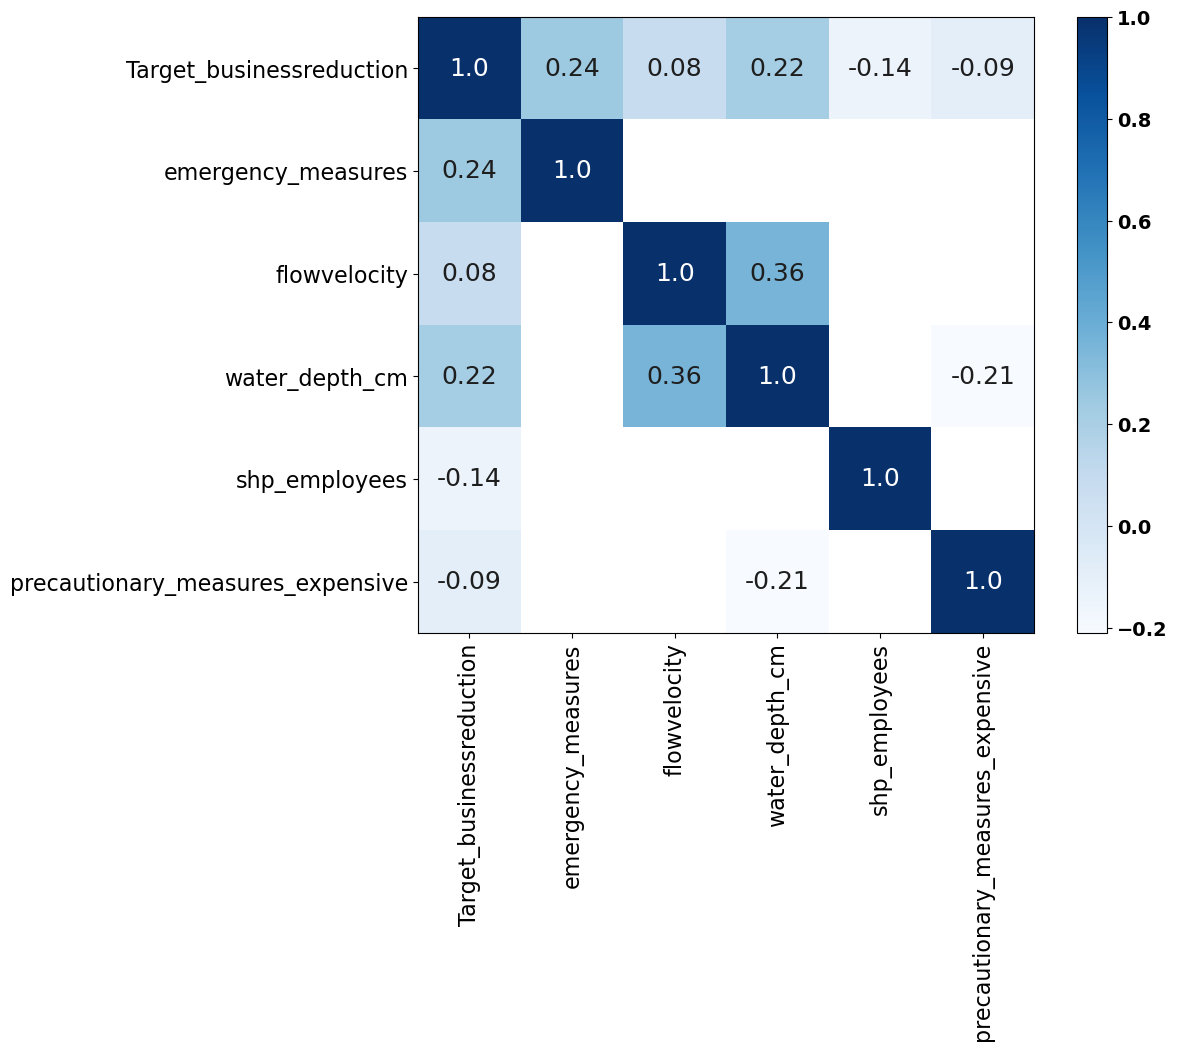

In [191]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don"t create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.

# precaution -0.0456 ** (no matter if pre-> wd or wd -> prec)

#### BN visualize

In [192]:
# #-----------------------------------------------------------------------------
# # Function 2 - bn_visualize - Plot of the Bayesian Network
# #-----------------------------------------------------------------------------

# ##  BN structure with graph + rank correlations on all b.reduction samples

# ## TODO change pybanhsee package for figure: make outpath adding possible (maybe rm prefix "BN_visualize_")
# fig_name =  f"bn_structure_{target}"

# df_hcmc_bn_plot = df_hcmc_bn.rename(
#     columns={
#         "precautionary_measures_expensive": "structural measures",
#         "flowvelocity" : "flow velocity",
#         "Target_businessreduction" : "rel. bred",
#         "shp_employees": "no. employees"
#     })

# bn_visualize(parent_cell,           # structure of the BN
#              R,                     # the rank correlation matrix (function 1)
#              df_hcmc_bn_plot.columns,          # names of variables
#              fig_name = fig_name)   # figure name
# # The plot presents the BN with x nodes and x arcs, with the (conditional)
# # rank correlations indicated on the arcs.

# bn_visualize(parent_cell,                       # structure of the BN
#              R,                                 # the rank correlation matrix 
#              df_hcmc_bn_plot.columns,                      # names of variables
#              data = df_hcmc_bn_plot,                       # DataFrame with data
#              fig_name = fig_name + '_margins')  # figure name
# # The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# # rank correlations indicated on the arcs. In this plot also the marginal
# # distributions for each variable are incorporated.


## Evaluation: HCMC


In [193]:
condition=[1, 2, 3, 4, 5]
# condition=[1, 2, 3, 4, 5, 6]
#condition=[1, 2, 3, 4, 5, 6, 7]
num_folds = 5
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)

## TODO fix workaround that always all records are used once for validation, currently 356 records and with 5 folds one sample has to been drop 
## --> write directly to df_hcmc_bn via index
# df_hcmc_bn = df_hcmc_bn[:-1]
# df_hcmc = df_hcmc.drop(df_hcmc_bn[-1:].index, axis=0) # nneded to calc abs loss

df_hcmc_bn_shuffle = df_hcmc_bn#.sample(frac=1)#.reset_index(drop=True)
# df_hcmc_bn_shuffle = df_hcmc_bn.sample(frac=1)#.reset_index(drop=True)
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
residuals_hcmc = pd.DataFrame()

for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_bn_shuffle[i*testset_size:][:testset_size] # 20% test   #TODO catch their index and write y_pred directly to input df
    train_nth_fold = df_hcmc_bn_shuffle[ ~df_hcmc_bn_shuffle.index.isin(test_nth_fold.index)] # 80% train
    # print(df_hcmc_bn_shuffle.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN train on fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,  
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  

    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix form train
                test_nth_fold,
                Output="mean")    # type of output data
                #Output="median")    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    residuals_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    residuals_hcmc = pd.concat([residuals_hcmc, residuals_per_fold], axis=0)

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    #print(f"Inference - Uncertainty distribution, fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())

    # A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
    # B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
    # correlation = (np.dot(B, A.T)/B.shape[0])
    # R2=correlation**2

    # # Calculate evaluation metrics
    # MAE = np.mean(np.abs(y_pred-y_true))
    # MBE = np.mean(y_pred-y_true)
    # RMSE = (np.mean((y_pred-y_true)**2))**(1/2)
    # print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 



# print(y_pred, y_true)

residuals_hcmc.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = OUTPATH_BN / f"bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = OUTPATH_BN / f"bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)



eu.empirical_vs_predicted(residuals_hcmc["y_true"], residuals_hcmc["y_pred"])


# 5 nodes , no f-exp, incl struct_precausion
# 0  17.562207 -1.082266  23.471596  61.942627 

# 6 nodes nonstruct_prec
# 0  17.364995 -0.865958  23.156208  61.754134 


Scores from fold 0: 13.972874647887325 1.0054380281690145 19.055772969250913 66.55305015370487
Scores from fold 1: 16.87554225352113 0.6952915492957747 21.449287129357135 68.36530894169272
Scores from fold 2: 18.91465352112676 -0.33069577464788724 23.880577638984143 57.66961222130223
Scores from fold 3: 16.71730845070422 1.3871112676056339 22.674878150297634 58.276781385369695
Scores from fold 4: 24.059439436619723 0.1285605633802822 31.854215202643715 57.20981847687535
Averaged evaluation scores of k-fold cross-validation (mean) :
          MAE       MBE       RMSE      SMAPE
0  18.107964  0.577141  23.782946  61.614914 
..saved to ..\model_results\bayesian_network\businessreduction\bn_performance_Target_businessreduction_hcmc.xlsx


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,355,10.0,18.157746,"[0, 100]",615.15,24.77,136.593059
predicted,355,17.0,18.219718,"[4, 100]",86.62,9.29,51.083097


In [194]:
## add binary dummy var for plotting zero-damage vs damage cases
residuals_hcmc["binary_true_dummy"] = 0
idx_damage = np.where(residuals_hcmc["y_true"] >= 1)[0]
residuals_hcmc["binary_true_dummy"].iloc[idx_damage] = 1


## add residuals
residuals_hcmc["residual"] = residuals_hcmc["y_pred"] - residuals_hcmc["y_true"]

### plot obs ~ pred

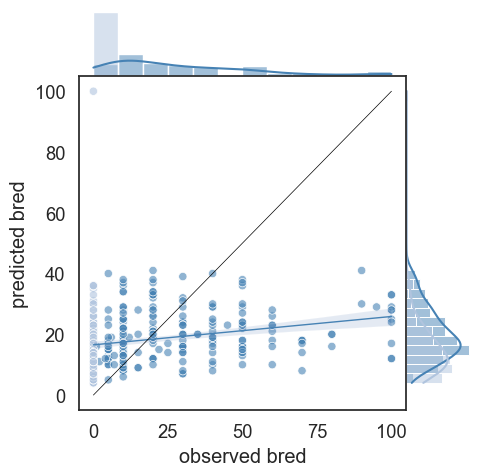

In [195]:
f.plot_observed_predicted(
    residuals_hcmc["y_true"], residuals_hcmc["y_pred"],  
    hue=residuals_hcmc["binary_true_dummy"], 
    hue_colors=("lightsteelblue","steelblue"), # if differentiation: set both time the same color
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}",
    legend=False, #True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_{target_plot}_hcmc.png"
)   

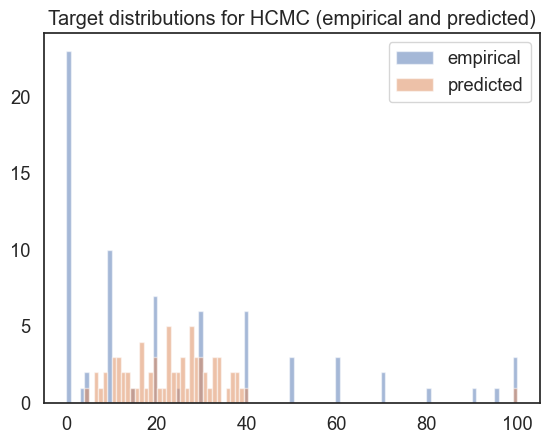

In [196]:

bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.5, label="empirical")
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.5, label="predicted")
plt.legend(loc="upper right")
plt.title("Target distributions for HCMC (empirical and predicted)")
plt.show()


### Main validation results

In [197]:
## get ratio of damage cases vs total reported bred

c = "y_pred"
print(len(np.where(residuals_hcmc[c] > 0.0)[0])) 
print(len(np.where(residuals_hcmc[c] > 0.0)[0]) / len(residuals_hcmc[c]) * 100, "%")
np.mean(residuals_hcmc[c])


355
100.0 %


18.219718309859154

#### plot confidence intervalls

In [198]:

for c in residuals_hcmc.columns:
    ci = eu.calc_confidence_interval(residuals_hcmc[c], confidence_level=0.95)


confidence interval: (15.568866906676284, 20.746626051070194) 
cases within interval: 29
confidence interval: (17.248224260957258, 19.19121235876105) 
cases within interval: 32
confidence interval: (0.5372978340208618, 0.6401669547115325) 
cases within interval: 0
confidence interval: (-2.466739070311298, 2.590682732283129) 
cases within interval: 25


In [199]:
# import numpy as np, scipy.stats as st

# confidence_level=0.95

# for c in residuals_hcmc.columns:
    
#     # conf_interval = st.t.interval(0.80, len(residuals_hcmc[c])-1, loc=np.mean(residuals_hcmc[c]), scale=st.sem(residuals_hcmc[c]))
#     # counts = ((residuals_hcmc[c] > conf_interval[0]) & (residuals_hcmc[c] <= conf_interval[1])).sum(axis=0)
#     conf_interval = st.t.interval(0.95, len(residuals_hcmc["y_pred"])-1, loc=np.mean(residuals_hcmc["y_true"]), scale=st.sem(residuals_hcmc["y_pred"]))
#     #counts = ((residuals_hcmc["y_pred"] > conf_interval[0]) & (residuals_hcmc["y_pred"] <= conf_interval[1])).sum(axis=0)
#     #print("confidence interval:", conf_interval, f"\ncases within interval: {counts}")



In [200]:
print(residuals_hcmc[["y_true","y_pred"]].describe())


           y_true      y_pred
count  355.000000  355.000000
mean    18.157746   18.219718
std     24.802221    9.307196
min      0.000000    4.000000
25%      0.000000   12.000000
50%     10.000000   17.000000
75%     30.000000   23.000000
max    100.000000  100.000000


#### Plot residuals

Text(0, 0.5, 'residuals (prediction - observation)')

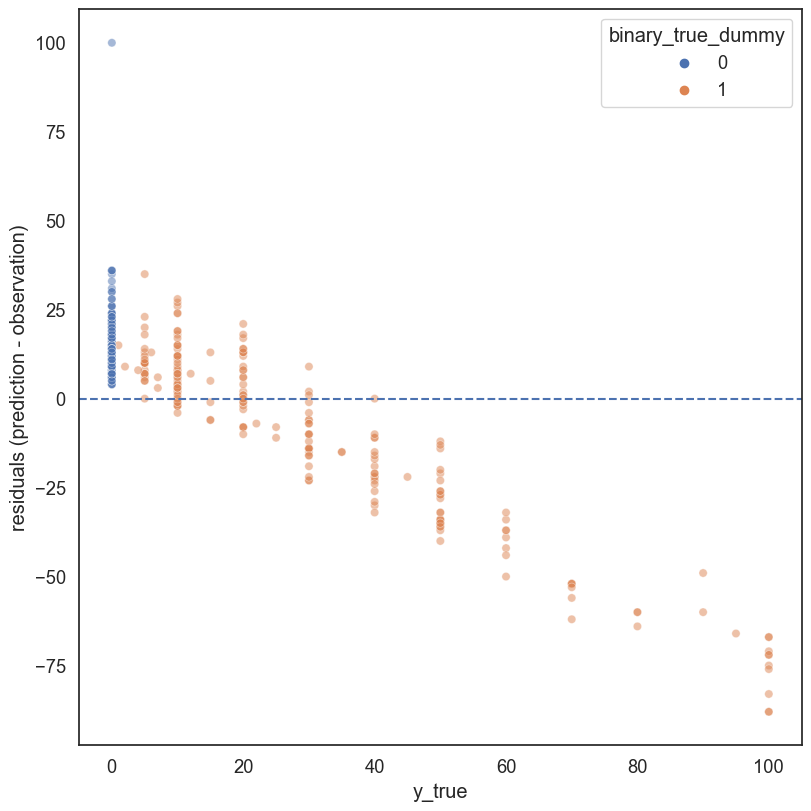

In [201]:
from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x = residuals_hcmc["y_true"], 
    y = residuals_hcmc["residual"], # pred - obs 
    hue = residuals_hcmc["binary_true_dummy"],
    #color = "steelblue",
    alpha = 0.5,
    #hue=df_hcmc_abred["abs_bred_true_dummy"]
    #palette=color_dict, edgecolors=color_dict
)
plt.ylabel("residuals (prediction - observation)")



### Absolute business reduction

In [203]:
# assert all(df_hcmc[target].tail(29).values ==  residuals_hcmc["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"

## TODO fix workaround that each record is used once for validation, currently 356 records and with 5 folds one sample has to been drop 
df_hcmc = df_hcmc[:-1]  # drop last record which is not caputred by 

assert all(df_hcmc[target].tail(29).values ==  residuals_hcmc["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"


In [204]:
df_hcmc[target].tail(10).values 
# residuals_hcmc["y_true"].tail(10).values

array([  0, 100,  40,  30,  20,  20,  30,  30,  10,  10], dtype=int64)

In [205]:

##  get first abs loss of only damage cases (only BN results) due that rcloss cases are all multiplied by chance of loss
df_hcmc_abred = df_hcmc_bn.copy()

## calc probably obs. abs bred
df_hcmc_abred["abred_true"] = df_hcmc_abred[target] * df_hcmc["shp_avgmonthly_sale_euro"] / 100
# df_hcmc_abred["abred_true"] = residuals_hcmc["y_true"] * df_hcmc["shp_avgmonthly_sale_euro"] / 100

## calc probably pred. abs bred
df_hcmc_abred["abred_pred"] = residuals_hcmc["y_pred"].reset_index(drop=True) *  df_hcmc["shp_avgmonthly_sale_euro"].reset_index(drop=True)  / 100 
# df_hcmc_abred["abred_pred"] = df_hcmc_abred[pred_target] *  df_hcmc_abred["shp_avgmonthly_sale_euro"] / 100 


## add binary dummy var for plotting zero-damage vs damage cases
df_hcmc_abred["binary_true_dummy"] = 0
idx_damage = np.where(residuals_hcmc["y_true"] >= 1)[0]
df_hcmc_abred.loc[idx_damage, "binary_true_dummy"] = 1
#df_hcmc_abred.describe()


## rm mising obsvation
df_hcmc_abred.dropna(inplace=True)

print("HCMC : absolute business interruption (zero-cases and damage cases)")
eu.empirical_vs_predicted(df_hcmc_abred["abred_true"], df_hcmc_abred["abred_pred"])


HCMC : absolute business interruption (zero-cases and damage cases)


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,354,13.0,69.192090,"[0, 1104]",20540.54,143.12,207.133063
predicted,354,35.0,64.655367,"[3, 773]",7923.59,88.89,137.675389


NOtes to  abs loss
- obs and pred mean are quite similar, underestimate higher losses

In [206]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from matplotlib.cbook import boxplot_stats  
from matplotlib.colors import to_rgba

def plot_observed_predicted_abs(y_true, y_pred, hue, hue_colors=("darkgrey","steelblue"), xlabel="observed", ylabel="predicted", alpha=0.6, legend=False, outfile="test.png"):
    """
    Scatter plot of observations vs predictions with optional class colors
    NOTE: hue is currently limited to binary cases
    # Code Snippet: https://stackoverflow.com/questions/66667334/python-seaborn-alpha-by-hue
    """

    sns.set(style="white", font_scale=1.2)

    color_dict = {
        0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
        1: to_rgba(hue_colors[1], alpha)
    }
    
    g = sns.JointGrid(
        x=y_true, y=y_pred, hue=hue,
        height=5, space=0,)
    # g.plot_joint(sns.scatterplot, palette=color_dict, edgecolors=color_dict, legend=legend)
    p = sns.scatterplot(
        x=y_true, y=y_pred, hue=hue, 
        palette=color_dict, edgecolors=color_dict, legend=legend, 
        ax=g.ax_joint)
    
    if legend is True:
        #p.legend(fontsize=10, )  # outside plot: bbox_to_anchor= (1.2,1)
        plt.setp(p.get_legend().get_texts(), fontsize='12')  
        plt.setp(p.get_legend().get_title(), fontsize='15')

    g.plot_marginals(sns.histplot, kde=False, palette=color_dict, multiple='stack')

    g1 = sns.regplot(
        x=y_true, y=y_pred, 
        line_kws={"lw":1.},
        scatter=False, ax=g.ax_joint)
    regline = g1.get_lines()[0]
    regline.set_color('steelblue')

    x0, x1 = (0, 100) 
    y0, y1 = (0, 100)
    lims = [min(x0, y0), max(x1, y1)]
    g.ax_joint.plot(lims, lims, c= "black", lw=.5,) # equal line
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)

    # save plot
    plt.savefig( outfile, dpi=300, bbox_inches="tight")

    plt.show()
   # plt.close()


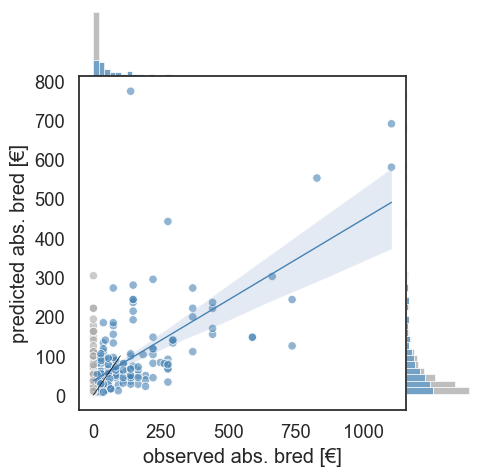

In [207]:
## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 
plot_observed_predicted_abs(
    y_true=df_hcmc_abred["abred_true"], y_pred=df_hcmc_abred["abred_pred"], 
    hue=df_hcmc_abred["binary_true_dummy"],
    xlabel=f"observed abs. bred [€]", ylabel=f"predicted abs. bred [€]",
    legend=False ,#True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_abs_bred_{target_plot}_hcmc.png"
)     


## Model transferability
Test trained NPBN for CanTHo DS

In [211]:
infile_name = "input_data_businessreduction_cantho"
df_cantho = pd.read_excel(f"../input_survey_data/{infile_name}.xlsx")

## prepare CanTHo for BN - adpat with same column structure as training dataset
df_cantho_bn = df_cantho[df_hcmc_bn.columns]
 
print(df_cantho_bn.shape)
df_cantho_bn.tail(2)

(313, 6)


,Target_businessreduction,emergency_measures,flowvelocity,water_depth_cm,shp_employees,precautionary_measures_expensive
311,50,0.444444,0.3,20,4,0.666667
312,50,0.111111,0.2,50,1,0.333333


### Prediction and Evaluation on CanTho Bred

In [212]:
condition=[1, 2, 3, 4, 5,] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              Output="mean")    # type of output data
              #Output="median")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())  #y_pred freq

## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_true=df_cantho_bn.iloc[:,0].to_numpy()

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_bn.iloc[:,0].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

print(f"\nObserved and predicted target distribution for CanTho:")
eu.empirical_vs_predicted(y_true, y_pred)

Inference - Uncertainty distribution:  count    313.000000
mean      40.987369
std        8.995855
min       20.811500
25%       35.660000
50%       40.790000
75%       44.945400
max      100.100000
dtype: float64
MAE,: 18.06014121405751
MAE, MBE, RMSE, SMAPE: 18.06014121405751 0.12474888178913686 23.8339643718442 23.476517409096168

Observed and predicted target distribution for CanTho:


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,313,40.0,40.862620,"[0, 100]",477.46,21.82,53.473876
predicted,313,40.0,40.479233,"[20, 100]",81.40,9.01,22.289030


In [213]:
residuals_cantho = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residual": pd.Series(y_pred) - pd.Series(y_true),  # + residual=overestim, -residual=underestimation of model
            },
            index=pd.Series(y_true).index)

## add binary dummy var for plotting zero-damage vs damage cases
residuals_cantho.reset_index(drop=True, inplace=True)
residuals_cantho["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho["y_true"] >= 1)[0]
residuals_cantho.loc[idx_damage, "binary_true_dummy"] = 1
residuals_cantho.describe()


print("Bred, cantho")
print(residuals_cantho.describe())


Bred, cantho
           y_true      y_pred    residual  binary_true_dummy
count  313.000000  313.000000  313.000000         313.000000
mean    40.862620   40.987369    0.124749           0.977636
std     21.850827    8.995855   23.871802           0.148102
min      0.000000   20.811500  -66.540800           0.000000
25%     25.000000   35.660000  -12.564300           1.000000
50%     40.000000   40.790000    0.854700           1.000000
75%     50.000000   44.945400   16.685600           1.000000
max    100.000000  100.100000  100.100000           1.000000


In [214]:
# f.plot_observed_predicted(
#     residuals["y_true"], residuals["y_pred"],  
#     hue=residuals["binary_dummy"], 
#     hue_colors=("lightsteelblue","steelblue"), # if differentiation: set both time the same color
#     xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}",
#     legend=False, #True
#     outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_{target_plot}_hcmc.png"
# )   

Plot obs ~ pred

In [215]:
f.plot_observed_predicted(
    residuals_cantho["y_true"], residuals_cantho["y_pred"],  
    hue=residuals_cantho["binary_true_dummy"],
    xlabel=f"observed {target_plot}", ylabel=f"predicted {target_plot}",
    legend=False, #True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_{target_plot}_cantho.png"
)       

# plt.xlabel("Model transferability, tested on Can Tho dataset")
# plt.show()

AttributeError: 'builtin_function_or_method' object has no attribute 'plot_observed_predicted'

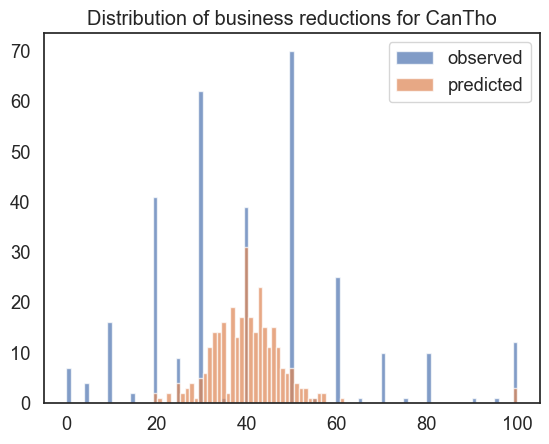

In [216]:
bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.7, label="observed")
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.7, label="predicted")
plt.legend(loc="upper right")
plt.title("Distribution of business reductions for CanTho")
plt.show()


### Main validation results


In [217]:
## get daamge / total
len(np.where(y_pred>0)[0])
np.mean(y_pred)

40.98736869009584

#### Plot confi. intervals

In [218]:

for c in residuals_cantho.columns:
    ci = eu.calc_confidence_interval(residuals_cantho[c], confidence_level=0.95)
    counts = ((residuals_cantho[c].values > ci[0]) & (residuals_cantho[c].values <= ci[1])).sum(axis=0)
    print(c, "confidence interval:", ci, f"\ncases within interval: {counts}")


confidence interval: (38.43247727930447, 43.29276233730895) 
cases within interval: 39
y_true confidence interval: [38.43 43.29] 
cases within interval: 39
confidence interval: (39.98689345804658, 41.9878439221451) 
cases within interval: 47
y_pred confidence interval: [39.99 41.99] 
cases within interval: 47
confidence interval: (-2.53015670020526, 2.779654463783533) 
cases within interval: 32
residual confidence interval: [-2.53  2.78] 
cases within interval: 32
confidence interval: (0.9611646245093961, 0.9941069409858116) 
cases within interval: 0
binary_true_dummy confidence interval: [0.96 0.99] 
cases within interval: 0


#### Plot residuals

Text(0, 0.5, 'residuals (prediction - observation)')

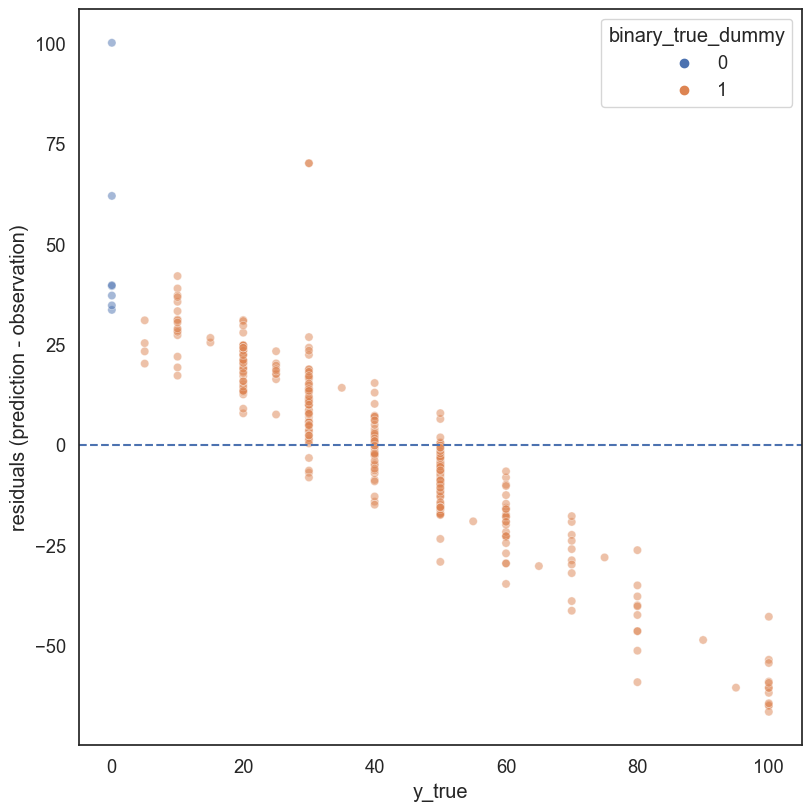

In [219]:
from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x = residuals_cantho["y_true"], 
    y = residuals_cantho["residual"], # pred - obs 
    hue = residuals_cantho["binary_true_dummy"],
    #color = "steelblue",
    alpha = 0.5,
    #hue=df_hcmc_abred["abs_bred_true_dummy"]
    #palette=color_dict, edgecolors=color_dict
)
plt.ylabel("residuals (prediction - observation)")





### Absolute business reduction

In [220]:
# assert (df_hcmc[target].values == df_hcmc_bn[target].values == residuals_hcmc["y_true"].values),
assert all(df_cantho[target].tail(29).values ==  residuals_cantho["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"

## TODO fix workaround that each record is used once for validation, currently 356 records and with 5 folds one sample has to been drop 
#df_cantho = df_cantho[:-1]  # drop last record which is not caputred by 

assert all(df_cantho[target].tail(29).values ==  residuals_cantho["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"
assert all(df_cantho_bn[target].tail(29).values ==  residuals_cantho["y_true"].tail(29).values),  "fix code were y_true is shuffled - residual df should have the same order as when it was loaded"


In [221]:
#df_hcmc[target].tail(10).values 
# residuals_hcmc["y_true"].tail(10).values

In [222]:

##  get first abs loss of only damage cases (only BN results) due that rcloss cases are all multiplied by chance of loss
df_cantho_abred = df_cantho_bn.copy()

## calc probably obs. abs bred
df_cantho_abred["abred_true"] = df_cantho_abred[target] * df_cantho["shp_avgmonthly_sale_euro"] / 100
# df_hcmc_abred["abred_true"] = residuals_hcmc["y_true"] * df_hcmc["shp_avgmonthly_sale_euro"] / 100

## calc probably pred. abs bred
df_cantho_abred["abred_pred"] = residuals_cantho["y_pred"].reset_index(drop=True) *  df_cantho["shp_avgmonthly_sale_euro"].reset_index(drop=True)  / 100 
# df_hcmc_abred["abred_pred"] = df_hcmc_abred[pred_target] *  df_hcmc_abred["shp_avgmonthly_sale_euro"] / 100 


## add binary dummy var for plotting zero-damage vs damage cases
df_cantho_abred["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho["y_true"] >= 1)[0]
df_cantho_abred.loc[idx_damage, "binary_true_dummy"] = 1


## rm mising obsvation
df_cantho_abred.dropna(inplace=True)

print("HCMC : absolute business interruption (zero-cases and damage cases)")
eu.empirical_vs_predicted(df_cantho_abred["abred_true"], df_cantho_abred["abred_pred"])


HCMC : absolute business interruption (zero-cases and damage cases)


,nobs,median,mean,min max,variance,standard deviation,coef variation
empirical,284,64.0,220.154930,"[0, 15390]",951937.40,973.95,443.175537
predicted,284,66.0,185.133803,"[4, 9100]",370901.06,607.94,328.960167


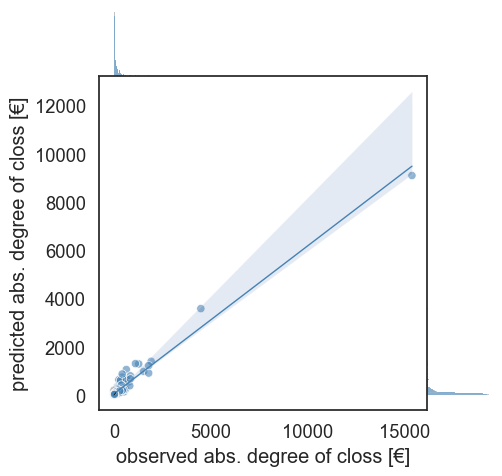

In [223]:
## TODO adapt x and y aixs to same limits -> use fixed max for xlim and ylim 
## TDO fix hue  all zero should be vertical  test mit =df_cantho_pred_cd["abred_true"]as binary
plot_observed_predicted_abs(
    y_true=df_cantho_abred["abred_true"], y_pred=df_cantho_abred["abred_pred"], 
    hue=df_cantho_abred["binary_true_dummy"],
    # hue_colors=("darkgrey","steelblue"),
    xlabel=f"observed abs. degree of closs [€]", ylabel=f"predicted abs. degree of closs [€]",
    legend=False ,#True
    outfile=rf"C:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\figures\scatter_obs_pred_abs_bred_{target_plot}_cantho.png"
)     


#### Chinh results for Can Tho (incl also SMEs)

In [224]:
### TODO update chinh result for bred

In [225]:
## get  reported losses in CHinh 2016 from USD [2011] to Euro [2020]

# # GDP deflator source : https://jp.tradingeconomics.com/united-states/gdp-deflator
gdp_price_index_2011 = 91.48  # 2011  #  chinh 2016 uses 2011 as reference year
gdp_price_index_2020 = 105.37 # price level 2020 based on GDP-deflation

# for r in range(len(vars_money.Target_contentloss_VND)):
chinh16_results = pd.DataFrame({
    "mean_degree_closs_usd": [118], # price level 2011 in USD
    "median_degree_closs_usd": [24] ,# price level 2011 in USD
    "mean_degree_closs_euro": [None],
    "median_degree_closs_euro": [None],
})
for r in range(len(chinh16_results.mean_degree_closs_usd)):
    chinh16_results["mean_degree_closs_euro"][r] = round(chinh16_results["mean_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro
    chinh16_results["median_degree_closs_euro"][r] = round(chinh16_results["median_degree_closs_usd"][r] * gdp_price_index_2020 / gdp_price_index_2011, 1)  # price level 2020 in Euro

chinh16_results

,mean_degree_closs_usd,median_degree_closs_usd,mean_degree_closs_euro,median_degree_closs_euro
0,118,24,135.9,27.6


### Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

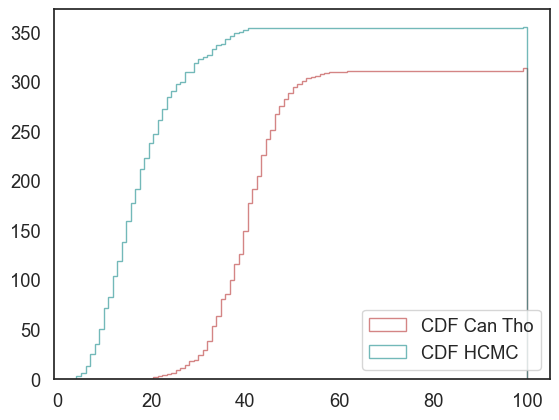

In [239]:
import numpy as np
from pylab import *


plt.hist(
    [residuals_hcmc["y_pred"], residuals_cantho["y_pred"]],   # pred. rel bred
    # [df_hcmc_abred["abred_pred"], df_cantho_abred["abred_pred"]], # pred. abs bred
    #bins=bins, 
    bins=100,
    # bins=15000,
    #normed=True, 
    cumulative=True,  
    histtype='step', alpha=0.55,
    color=("teal","firebrick"), 
    label=("CDF HCMC", "CDF Can Tho"),
)
# # bins and (lognormal / normal) datasets are pre-defined
plt.legend(loc='best')


# # Create some test data
# dx = 0.01
# # Normalize the data to a proper PDF
# Y /= (dx * Y).sum()

# # Compute the CDF
# X = df_hcmc_bn[target]
# Y = df_hcmc_bn[target]
# CY = np.cumsum(Y * dx)
# plot(X, Y)
# plot(X, CY, 'r--')
# show()



In [235]:
bins

array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.28282828,  29.29292929,  30.3030303 ,  31.31313131,
        32.32323232,  33.33333333,  34.34343434,  35.35353535,
        36.36363636,  37.37373737,  38.38383838,  39.39393939,
        40.4040404 ,  41.41414141,  42.42424242,  43.43434343,
        44.44444444,  45.45454545,  46.46464646,  47.47474747,
        48.48484848,  49.49494949,  50.50505051,  51.51515152,
        52.52525253,  53.53535354,  54.54545455,  55.55555556,
        56.56565657,  57.57575758,  58.58585859,  59.5959596 ,
        60.60606061,  61.61616162,  62.62626263,  63.63

## Distirbutions Bred for CnaTho and HCMC

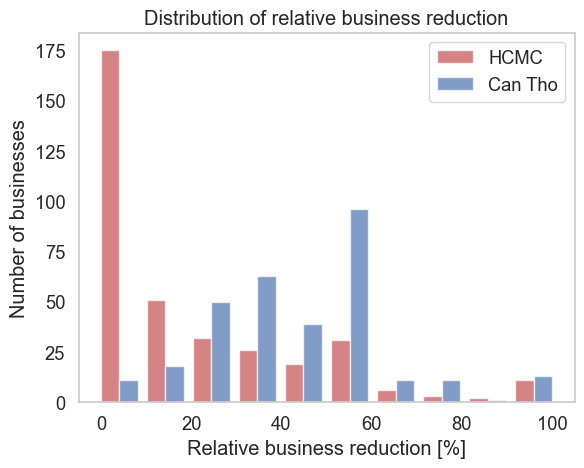

In [156]:
#bins = np.linspace(0, 100, 100)
#plt.hist(df_hcmc_bn["Target_businessreduction"], bins, alpha=0.7, label="HCMC")
#plt.hist(df_cantho["Target_businessreduction"], bins, alpha=0.7, label="Can Tho")

import seaborn as sns

# sns.set_theme()  # <-- This actually changes the look of plots.
sns.set_style("whitegrid", {"axes.grid" : False})
fig, ax = plt.subplots()
plt.hist(
    [
        df_hcmc_bn["Target_businessreduction"], 
        df_cantho_bn["Target_businessreduction"]
    ], 
    color=["r","b"], alpha=0.7,  
    label=["HCMC", "Can Tho"],
    # bins=range(-1, 101, 10)
    bins = np.linspace(-1, 101, 11)
)

# TODO make to 10 bins with equal ranges

plt.legend(loc="upper right")
plt.xlabel("Relative business reduction [%]")
plt.ylabel("Number of businesses")
plt.title("Distribution of relative business reduction")# (source: survey datasets)
plt.show()

In [157]:
print(df_hcmc_bn["Target_businessreduction"].value_counts())
df_cantho_bn["Target_businessreduction"].value_counts()

Target_businessreduction
0      147
10      45
20      29
30      24
50      23
5       22
40      18
100     10
60       8
70       6
15       5
80       3
25       2
7        2
35       2
90       2
45       1
12       1
6        1
2        1
1        1
22       1
95       1
4        1
Name: count, dtype: int64


Target_businessreduction
50     70
30     62
20     41
40     39
60     25
10     16
100    12
80     10
70     10
25      9
0       7
5       4
15      2
35      1
95      1
55      1
90      1
65      1
75      1
Name: count, dtype: int64

Leftovers

In [158]:
## resilneceLeftAlon
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA ***
# MAE, MBE, RMSE, R2: 17.200156373937677 0.4218543909348444 23.15446102273047 0.10639659042647506
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, employees -> resilLA (sm shp feel left alon) ***
# MAE, MBE, RMSE, R2: 17.176264589235128 0.4530617563739379 23.124443137322782 0.108357373657999
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, employees -> resilLA -> emerg
# MAE, MBE, RMSE, R2: 17.1957447592068 0.5416563739376764 23.123202603045744 0.10895224317309785

## resilience  + precaution
## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA, prec_cheap *********
# MAE, MBE, RMSE, R2: 17.027345609065158 -0.01665269121813176 23.048158649799895 0.11250114114029462
## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA -> prec_cheap,  *********
# MAE, MBE, RMSE, R2: 17.025917847025497 -0.04757223796034028 23.049739182418246 0.11223725255180217

## 6  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, resilLA, prec_cheap -> wd
# MAE, MBE, RMSE, R2: 17.03888611898017 -0.029772237960340845 23.053894013392544 0.11193013239781474


## bred for CanTHo (all sectors)
## 1 feature (fv) (predictor with strongest unconditional correlation to target)
# MAE, MBE, RMSE, R2: 19.505287818696882 3.023567138810198 24.160341209664693 0.04181915781958483

## 2 features (fv , eme): 
# MAE, MBE, RMSE, R2: 19.74858300283286 4.847018130311617 24.102795696439568 0.07470495711283799
## 2 features (fv -> eme):  **
# MAE, MBE, RMSE, R2: 19.50758866855524 4.4753994334277625 23.847507546059752 0.08311888467028201


## 3 features (fv -> eme, wd): 
# MAE, MBE, RMSE, R2: 19.812639376770537 4.699533994334278 24.505799118556922 0.05333127112893681
# (fv, wd) -> emer                                                                
# MAE, MBE, RMSE, R2: 19.681899150141643 5.419263456090651 24.4689403027466 0.0773554306974711
## 3 features (wd -> fv -> eme): 
# MAE, MBE, RMSE, R2: 19.35493597733711 4.44363059490085 24.164246571908436 0.07249607165736519
# wd -> fv -> emerg, wd -> emer    **
# MAE, MBE, RMSE, R2: 19.268610198300284 4.345695750708216 24.10171438023097 0.07410980916779679

## 4 features  wd -> fv -> emerg, wd -> emer , bage OR wd -> fv -> emerg, wd -> emer, bage -> emer 
# MAE, MBE, RMSE, R2: 22.523064589235126 9.747832861189801 30.487814466673964 0.04561359169218263

## 4 features  wd -> fv -> emerg, wd -> emer , employees 
# MAE, MBE, RMSE, R2: 18.175970538243625 1.9748232294617563 23.62099298041095 0.0823823705515876

## 4 features  wd -> fv -> emerg, wd -> emer , employees -> emerg **
# MAE, MBE, RMSE, R2: 18.114451558073654 2.0018022662889505 23.521324314751425 0.08837952332919242


## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg **
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419

# 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682

## NOTE flood_experience destn had much to the correlation matrix
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg ***
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419
# MAE, MBE, RMSE, R2: 18.049626912181303 1.9718960339943339 23.472259684081735 0.09114064236879915

## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, wd -> f_exp  or (fv, wd ) -> f_exp
# MAE, MBE, RMSE, R2: 18.04273852691218 1.8733560906515578 23.485209176707 0.08947400855478219
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, empyees -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.151970254957504 2.005811614730878 23.605126298988313 0.08341479771829687
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, fv -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.087845042492916 1.9727124645892347 23.54767208649904 0.08669006220384032
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, (fv, wd) -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.033663456090654 1.906552407932011 23.483206802412496 0.090087138456569
# MAE, MBE, RMSE, R2: 18.07102379603399 1.963625495750708 23.48455980772728 0.09018022497710662
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp
# MAE, MBE, RMSE, R2: 18.15713569405099 1.9102444759206798 23.624181609497047 0.08180727515554582
## 5  features  wd -> fv -> emerg, wd -> emer , f_exp -> employees -> emerg **
# MAE, MBE, RMSE, R2: 18.083003966005666 1.9070526912181294 23.52099952528106 0.08762798639808682
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, empyees -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.151970254957504 2.005811614730878 23.605126298988313 0.08341479771829687
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, fv -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.087845042492916 1.9727124645892347 23.54767208649904 0.08669006220384032

## NOTE flood_experience doestn add much to the correlation matrix . corr ~ 0.02
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, f_exp -> emerg **
# MAE, MBE, RMSE, R2: 18.02483654390935 1.8803764872521245 23.47399253197319 0.09032304789434419
# MAE, MBE, RMSE, R2: 18.049626912181303 1.9718960339943339 23.472259684081735 0.09114064236879915
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, wd -> f_exp  or (fv, wd ) -> f_exp
# MAE, MBE, RMSE, R2: 18.04273852691218 1.8733560906515578 23.485209176707 0.08947400855478219
## 5  features  wd -> fv -> emerg, wd -> emer , employees -> emerg, (fv, wd) -> f_exp -> emerg 
# MAE, MBE, RMSE, R2: 18.033663456090654 1.906552407932011 23.483206802412496 0.090087138456569
# MAE, MBE, RMSE, R2: 18.07102379603399 1.963625495750708 23.48455980772728 0.09018022497710662

## NOTE decrease in BN by adding barea or content value as 5th var (insted f exp)




## bred for HCMC (all sectors)

## 1 feature (fv) (predictor with strongest unconditional correlation to target)
# MAE, MBE, RMSE, R2: 19.505287818696882 3.023567138810198 24.160341209664693 0.04181915781958483

## 2 features (fv , wd): 
#MAE, MBE, RMSE, R2: 19.666353824362606 4.0971328611898015 24.724952060748617 0.0445429230009319
## 2 features (fv -> wd):
# MAE, MBE, RMSE, R2: 19.27965014164306 3.0124597733711056 24.42307087930957 0.03853784201023082
## 2 features (wd -> fv): *** 
# MAE, MBE, RMSE, R2: 19.19400849858357 3.0263410764872525 24.32564070748576 0.04346755981646989

## 3 features (fv -> wd, ind) or 3 features (fv -> wd, ind-> wd): 
# MAE, MBE, RMSE, R2: 19.85800424929178 3.829028611898017 26.26434191775025 0.021068001106892515
## 3 features (inund -> fv -> wd): 
# MAE, MBE, RMSE, R2: 20.061832861189803 4.209602266288951 26.296466395722444 0.022958052067840833
## 3 features (fv -> inund -> wd) or (fv -> wd -> inund): 
# MAE, MBE, RMSE, R2: 20.360632577903683 5.158526628895184 26.629869881681152 0.028134408947895335
## 3 features (fv -> wd, f_exp): 
# MAE, MBE, RMSE, R2: 19.49173371104816 3.5954328611898014 24.485946638578397 0.04108387664484545
## 3 features (fv -> wd, fv -> f_exp) or (fv -> wd, wd -> f_exp): 
# MAE, MBE, RMSE, R2: 19.437306232294617 3.5750371104815866 24.4236399033457 0.04324104053604041
# MAE, MBE, RMSE, R2: 19.4146730878187 3.5007552407932008 24.4052399553994 0.04337155544398731

## 3 features (fv -> wd, b area): 
# MAE, MBE, RMSE, R2: 19.694199716713882 3.3882450424929176 25.499697335228188 0.016091008515160106
## 3 features (b area -> fv -> wd, ) or ( (b area, fv) -> wd, )
# MAE, MBE, RMSE, R2: 19.644013597733707 3.452292351274788 25.443190103627895 0.018462419021187275
# MAE, MBE, RMSE, R2: 19.632755524079318 3.3500699716713886 25.43108857960936 0.01756801044079168
